In [224]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
from gymnasium import spaces
from tqdm import trange
from stable_baselines3 import PPO

from notebooks.datasets.SP100Stocks import SP100Stocks

# S&P100 weights optimization via Deep Reinforcement Learning
The goal of this notebook is to build an agent capable of learning the optimal weights for the S&P100 index that give the best returns. The agent will try to outperform an equally weighted portfolio, meaning that each stock has the same weight.

## Loading the data
The data from the custom PyG dataset for containing the historical prices and the graph structure of the stocks is loaded.
For this task, a longer time series than the previous ones is needed. Here 200 days of data is considered, which corresponds to 40 weeks.

In [38]:
episode_duration = 200
seq_len = 25
dataset = SP100Stocks(past_window=seq_len)
dataset, dataset[0]

(SP100Stocks(1208),
 Data(x=[100, 5, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

The data is split into a training and testing set. The testing contains the last `seq_len` days of the dataset. The training set contains the rest of the data.

In [39]:
# train_episodes has the shape (n_episodes, episode_duration, n_stocks, n_features, seq_len)
train_episodes = [
	dataset[i:i+episode_duration] for i in trange(len(dataset)-episode_duration, desc='Creating training episodes', position=0)
]
random.shuffle(train_episodes)

test_episode = dataset[-episode_duration:]
len(train_episodes), train_episodes[0], test_episode

Creating training episodes: 100%|██████████| 1008/1008 [04:13<00:00,  3.98it/s]


(1008, SP100Stocks(200), SP100Stocks(200))

## Reinforcement Learning Environment
The environment is defined using the Gymnasium API.
- State

The observations are the graphs of the stocks at each time step, where nodes contain data on the last `n` days (variation, price, RSI, ...).
- Action

The action space is a continuous space of size (n_stocks,) where the agent can choose the weights for each stock. We need $\sum_{i=1}^{n} a_i = 1$, where $a_i$ is the weight of stock $i$. A simple way to achieve this is to apply a softmax on the output of the agent.
- Reward

The goal of the agent is to beat the baseline, which is an equally weighted portfolio. The reward is a function of the difference between the agent's performance and the baseline's performance. The reward is calculated with a sigmoid function as follows:
$$
r = \left( \frac{1}{1 + e^{b - a}} - 0.5 \right) \times c
$$
where $b$ is the baseline performance, $a$ is the agent's performance, and $c$ is a reward coefficient.

In [219]:
class SP100Env(gym.Env):
	metadata = {'render.modes': ['human']}
	def __init__(self, n_stocks: int, n_features, seq_len: int, train_episodes: list[SP100Stocks], test_episode: SP100Stocks, render_mode: str = None, reward_coef: float = 50):
		super(SP100Env, self).__init__()
		self.n_stocks: int = n_stocks
		self.n_features: int = n_features
		self.seq_len: int = seq_len
		self.episode_length: int = len(train_episodes[0])
		self.reward_coef: float = reward_coef
		
		self.train_episodes: list[SP100Stocks] = train_episodes
		self.test_episode: list[SP100Stocks] = test_episode
		
		self.current_episode: SP100Stocks = train_episodes[0]
		self.current_step: int = 0
		
		assert render_mode is None or render_mode in self.metadata["render_modes"]
		self.render_mode: str = render_mode

		self.action_space: spaces.Box = spaces.Box(low=0, high=1, shape=(n_stocks,), dtype=np.float32)
		self.observation_space: spaces.Dict = spaces.Dict({
			'x': spaces.Box(low=-np.inf, high=np.inf, shape=(n_stocks, n_features, seq_len), dtype=np.float32),
			'edge_index': spaces.Box(low=0, high=n_stocks-1, shape=(2, n_stocks), dtype=np.int64),
	    'edge_weight': spaces.Box(low=0, high=1, shape=(n_stocks,), dtype=np.float32),
		})
		
		self.baseline_weights: np.ndarray = np.ones(n_stocks) / n_stocks
		self.current_baseline_performance: float = 1.
		self.current_agent_performance: float = 1.
		
	def reset(self, seed=None, options=None) -> dict:
		self.current_episode = random.choice(self.train_episodes)
		self.current_step = 0
		self.current_baseline_performance = 1.
		self.current_agent_performance = 1.
		
		self.render()
		return self._get_observation()
	
	def step(self, action: np.ndarray) -> tuple[dict, float, bool, dict]:
		assert self.action_space.contains(action)
		assert action.shape == (self.n_stocks,)
		assert np.isclose(np.sum(action), 1)
		
		next_day_variations = self.current_episode[self.current_step + 1].x[:, 2, -1].numpy() / 100  # variations are in percentage
		
		baseline_variations = np.sum(next_day_variations * self.baseline_weights)
		action = np.random.randn(self.n_stocks)  # random agent
		agent_variations = np.sum(next_day_variations * action)
		
		self.current_baseline_performance *= (1 + baseline_variations)
		self.current_agent_performance *= (1 + agent_variations)
				
		self.current_step += 1
		observation = self._get_observation()
		reward = self._get_reward(baseline_variations, agent_variations)
		terminated = self.current_step >= self.episode_length - 1  # -1 because the next day is needed to calculate the reward
		
		self.render()
		
		if terminated:
			self.reset()
		
		return observation, reward, terminated, False, {}
	
	def render(self) -> None:
		if self.render_mode == 'human':
			print(f'Current step: {self.current_step}/{self.episode_length}')
			print(f'Baseline performance: {self.current_baseline_performance}')
			print(f'Agent performance: {self.current_agent_performance}')

	def close(self):
		pass
	
	def _get_observation(self) -> dict:
		return {
			'x': self.current_episode[self.current_step].x.numpy(),
			'edge_index': self.current_episode[self.current_step].edge_index.numpy(),
			'edge_weight': self.current_episode[self.current_step].edge_weight.numpy(),
		}
	
	def _get_reward(self, step_baseline_performance: float, step_agent_performance: float) -> float:
		return (1 / (1 + np.exp(step_baseline_performance - step_agent_performance)) - .5) * self.reward_coef

In [222]:
n_stocks, n_features = dataset[0].x.shape[0], dataset[0].x.shape[1]

env = SP100Env(n_stocks=n_stocks, n_features=n_features, seq_len=seq_len, train_episodes=train_episodes, test_episode=test_episode)

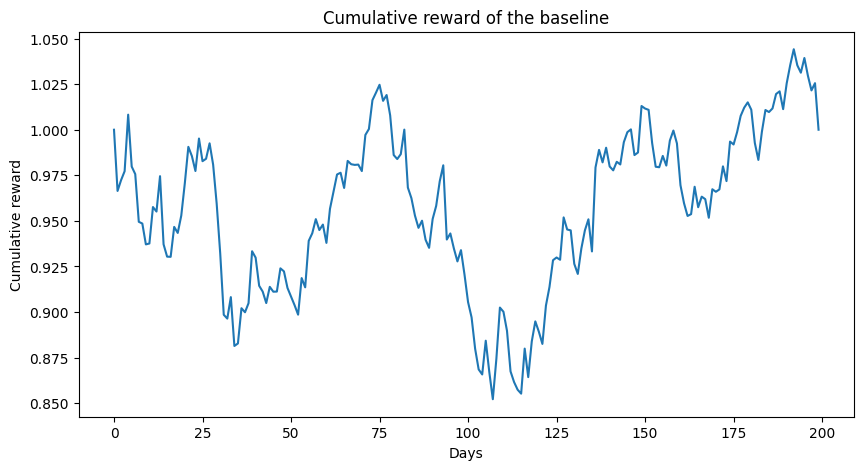

In [223]:
plt.figure(figsize=(10, 5))

baseline_rewards = []
for i in range(200):
	baseline_rewards.append(env.current_baseline_performance)
	env.step((np.ones(n_stocks) / n_stocks).astype(np.float32))

plt.plot(baseline_rewards)

plt.xlabel('Days')
plt.ylabel('Equals weights S&P100 variation')
plt.title('Variation')
plt.show()